# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk as nlp
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Dataset
## Load data

In [2]:
df_fake = pd.read_csv("../datasets/fake.csv")
df_real = pd.read_csv("../datasets/real.csv")

## Exploratory Data Analysis

In [3]:
print(f"Fake news dataset has {df_fake.shape[0]} entries.")
df_fake.head()

Fake news dataset has 23481 entries.


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
# Missing values
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [5]:
print(f"Real news dataset has {df_real.shape[0]} entries.")
# Missing values
df_fake.isnull().sum()

Real news dataset has 21417 entries.


title      0
text       0
subject    0
date       0
dtype: int64

In [6]:
# Concatenate the datasets and add a label column
df_fake['label'] = 'fake'
df_real['label'] = 'real'
dataset = pd.concat([df_fake, df_real])
dataset = dataset.sample(frac=1).reset_index(drop=True)

/tmp/ipykernel_270426/2697658395.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')
/tmp/ipykernel_270426/2697658395.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{counts[i] / len(dataset) * 100 :.2f}%', ha='center')


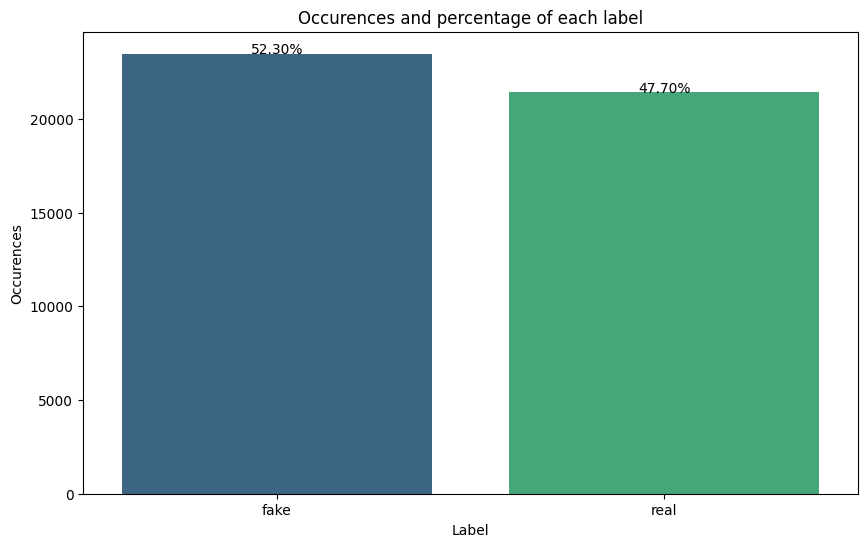

In [7]:
counts = dataset['label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')

for i, count in enumerate(counts):
    plt.text(i, count + 0.5, f'{counts[i] / len(dataset) * 100 :.2f}%', ha='center')

# Set labels and title
plt.xlabel('Label')
plt.ylabel('Occurences')
plt.title('Occurences and percentage of each label')

plt.show()


In [8]:
# Subjects count
dataset.subject.value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

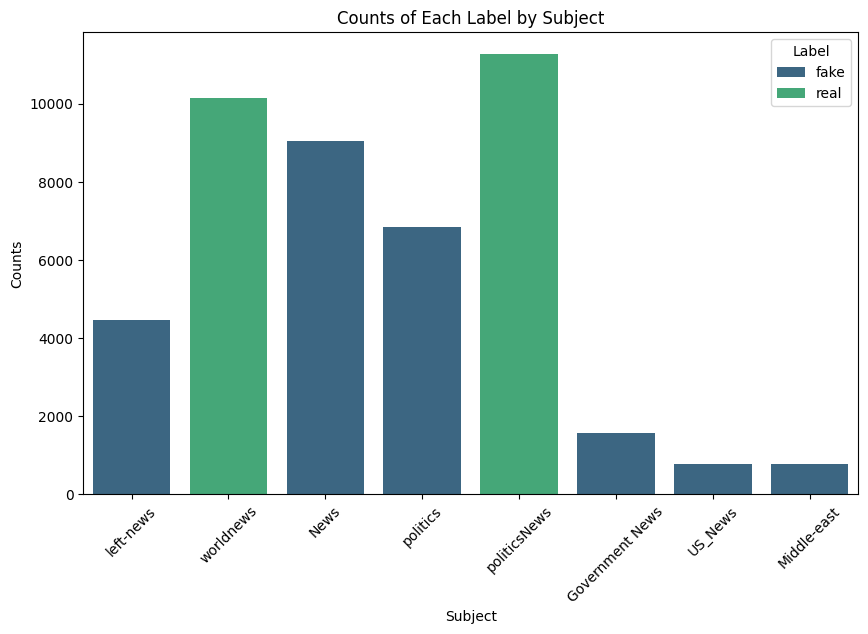

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', hue='label', data=dataset, palette='viridis')
plt.title('Counts of Each Label by Subject')
plt.xlabel('Subject')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='Label', loc='upper right')
plt.show()

As we see, the subjects in the dataset and the labels "fake"/"real" news are already sorted, meaning there is no reason to calculate the correlation.

# Data preprocessing

In order for the machine to be able to comprehend the input, get trained and provide predictions, the text should be converted in numbers. However, we need to reduce the complexity as well, by grouping words with the same root (e.g. sending should become send). There are 2 approaches that one can follow:
- stemming
- lemmatization
In stemming, we remove suffixes or prefixes from words to extract their root form, while lemmatization determines the lemma or dictionary form of a word based on its intended meaning. With lemmatization, the word `better` will be assiciated with `good` and `happier` with `happy`. In stemming the word `happier` may be associated (incorrectly) with `happi`.

It's clear that lemmatization may require more time to be completed than stemming.

## Remove stopwords
Furthermore, we nned to remove the words that are used in any language used to connect words or used to declare the tense of sentences, since they do not add much meaning to the context of the sentence so even after removing the stopwords we can understand the context.

## Tokenization
Tokenization is the process of breaking text into smaller pieces which we know as tokens. Each word, special character, or number in a sentence can be depicted as a token in NLP.

In [10]:
nlp.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)
nlp.download('wordnet')
nlp.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vasilis/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/vasilis/nltk_data...


{'through', 'here', 'me', 'off', 'who', 'don', 'themselves', 'all', 'if', 'there', 'such', "mustn't", 'how', 'have', 'yourselves', 'ourselves', 'we', 'and', 'where', 'does', 'on', 'once', 'again', 'needn', 'then', 'between', 'which', 'o', 'their', "won't", 'those', 'theirs', 'his', 'in', 'by', 'this', 'won', 'did', 'weren', "should've", 'hasn', 'her', 'with', 'myself', 'be', "aren't", 'has', 'before', 'yourself', 'further', 'down', 's', 'my', 'an', 'at', "weren't", 'mightn', 'wasn', 'what', 've', 'just', 'isn', 'nor', 'but', 'the', 'a', "hasn't", 'after', "you'll", "doesn't", 'when', 'whom', 'few', 'were', 'while', 'both', 'it', 'yours', "you've", 'for', 'out', "haven't", 'own', "needn't", 'is', 'any', 'most', 'been', 'will', 'now', 'shan', 'itself', 'into', 'above', 'haven', 'himself', 'aren', 'our', 'your', 'do', 'should', 'didn', 'hadn', 'that', 'y', 'herself', 'are', 'them', 'doing', 'same', "shouldn't", "hadn't", 'against', 'each', 'having', "wasn't", "isn't", 'until', 'mustn', 'm

[nltk_data] Downloading package punkt to /home/vasilis/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
# Split input output
x = dataset.text
y = dataset.label

In [12]:
# lemmatization function
def clean_and_lemmatize_text(text):
    # Convert the text string to lowercase
    text = text.lower()
    
    # Tokenize the text string
    tokens = word_tokenize(text)

    # Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Initialize WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Apply lemmatization to each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the lemmatized tokens back into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text    

## Data preperation

In [13]:
print(f'The first news sample before data preparation:\n\n{x[0]}')
# Lemmatize & remove stopwords
x = x.apply(clean_and_lemmatize_text)

The first news sample before data preparation:

President Trump s Secretary of Education, Betsy DeVos spoke today at George Mason University s Virginia campus. DeVos ignited a firestorm when she announced the end of yet another case of an unlawful overreach by Barack Obama, that affected every college student by stripping them of their right to due process in sexual assault cases.DeVos explained her reasoning for reversing an unfair and impractical solution to sexual assault on campuses:  Survivors, victims of a lack of due process, and campus administrators, have all told me that the current approach does a disservice to everyone involved. A student says he or she was sexually assaulted by another student on campus. If he or she isn t urged to keep quiet, or discouraged from reporting it to local law enforcement, the case goes to a school administrator, who will act as the judge and jury. The accused may or may not be told of the allegations before a decision is rendered. If there is 

In [14]:
print(f'The first news sample after data preparation:\n\n{x[0]}')

The first news sample after data preparation:

president trump secretary education , betsy devos spoke today george mason university virginia campus . devos ignited firestorm announced end yet another case unlawful overreach barack obama , affected every college student stripping right due process sexual assault cases.devos explained reasoning reversing unfair impractical solution sexual assault campus : survivor , victim lack due process , campus administrator , told current approach disservice everyone involved . student say sexually assaulted another student campus . urged keep quiet , discouraged reporting local law enforcement , case go school administrator , act judge jury . accused may may told allegation decision rendered . hearing , survivor accused , may may allowed legal representation . whatever evidence presented may may shown party . notion school must diminish due process right better serve victim creates victim . better way also mean demand anyone become something not.s

In [15]:
x = x.to_numpy()
y = y.replace('real', 1)
y = y.replace('fake', 0)
y = y.to_numpy()

/tmp/ipykernel_270426/1507289045.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace('fake', 0)


## Vectorization
Now we are goint to convert text data into numerical representations suitable for machine learning algorithms.

###  CountVectorizer
Is used to convert a collection of text documents into a matrix of token counts. It counts the number of times a token shows up in the document and uses this value as its weight.

### TfidfTransformer
Transform a count matrix to a normalized term-frequency or term-frequency times inverse document-frequency (TF-IDF) representation. TF-IDF reflects the importance of a word in a document relative to a collection of documents.

### TfidfVectorizer
TF (Term Frequency):  In the document, words are present so many times that is called term frequency. In this section, if you get the largest values it means that word is present so many times with respect to other words. when you get word is parts of speech word that means the document is a very nice match.

IDF (Inverse Document Frequency): in a single document, words are present so many times, but also available so many times in another document also which is not relevant. IDF is a proportion of how critical a term is in the whole corpus.


In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(x)
freq_term_matrix = count_vectorizer.transform(x)
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

# TfidfVectorizer can perform all the above steps at once
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(x)


In [17]:
# Splitting the data into test data and train data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tf_idf_matrix,y, random_state=0)

# Modeling
For different models will be used and compared:
- Logistic Regression
- Naive-Bayes
- Decision Tree
- Passive-Aggressive Classifier.
## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
lg_accuracy = logreg.score(x_test, y_test)
y_pred_lg = logreg.predict(x_test)
print(f'Logistic regression accuracy : {round(lg_accuracy*100,2)}%')

Logistic regression accuracy : 98.96%


## Naive-Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train, y_train)
nb_accuracy = NB.score(x_test, y_test)
y_pred_nb = NB.predict(x_test)
print(f'Naive-Bayes accuracy : {round(nb_accuracy*100,2)}%')

Naive-Bayes accuracy : 94.5%


## Decission tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
dt_accuracy = clf.score(x_test, y_test)
y_pred_dt = clf.predict(x_test)
print(f'Decission tree accuracy : {round(dt_accuracy*100,2)}%')

Decission tree accuracy : 99.63%


## Passive-Aggressive Classifier

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(x_train,y_train)
y_pred_pac = pac.predict(x_test)
pac_accuracy = accuracy_score(y_test,y_pred_pac)
print(f'Passive aggressive classifier accuracy : {round(pac_accuracy*100,2)}%')

Passive aggressive classifier accuracy : 99.56%


# Plot results

In [22]:
import sklearn.metrics as metrics                                                 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

def plotConfusionMatrix(y_pred, graph_title, y_test):
    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_confusion_matrix(conf_mat=cm,
                          show_absolute=True,
                          show_normed=True,
                          colorbar=True,
                          class_names=['Real', 'Fake'])
    plt.title(graph_title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    

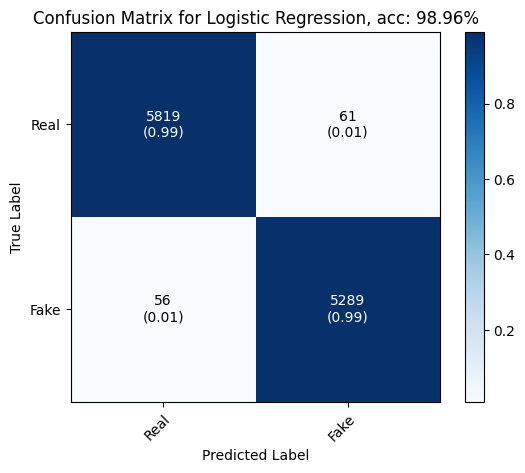

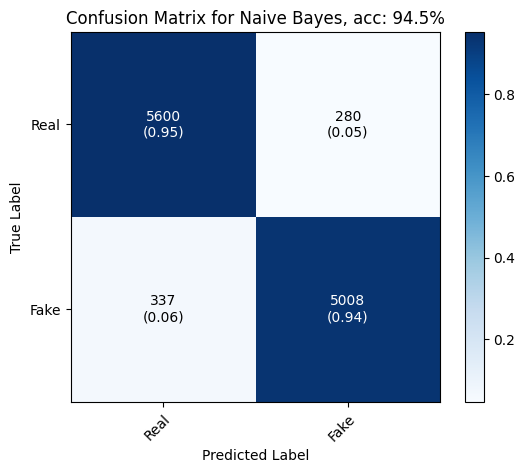

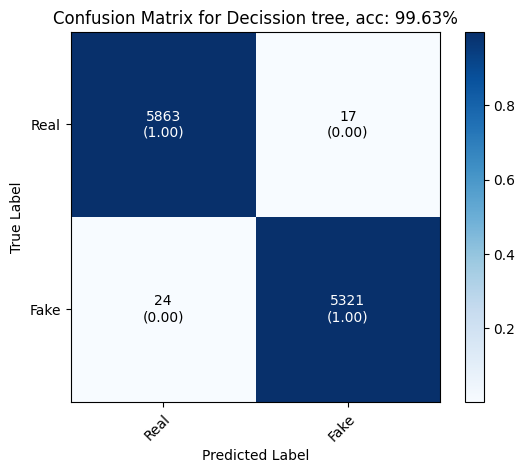

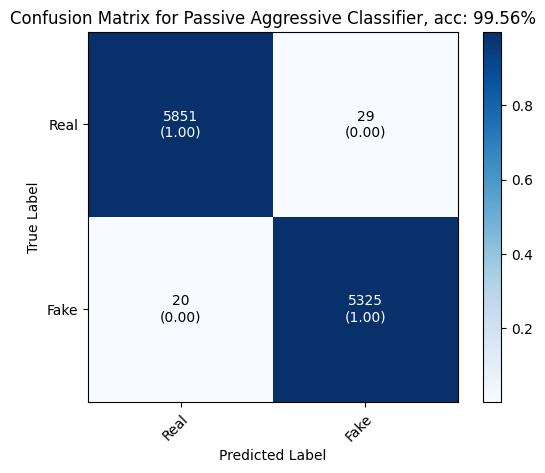

In [23]:
predictions = [y_pred_lg, y_pred_nb, y_pred_dt, y_pred_pac]
models = ['Logistic Regression', 'Naive Bayes', 'Decission tree', 'Passive Aggressive Classifier']
accuracies = [lg_accuracy, nb_accuracy, dt_accuracy, pac_accuracy]

for y_pred, model, accuracy in zip(predictions, models, accuracies):
    title = f'Confusion Matrix for {model}, acc: {round(accuracy*100,2)}%'
    plotConfusionMatrix(y_pred, title, y_test)